# Using Recipe Ingredients to Categorize Cuisine

By Eka Renardi. October 19, 2015

## 1. Introduction

Kaggle posed a challenge for predicting the category of cuisine based on its recipe ingredients. This document outlines my approach for solving this Kaggle Competition. 

## 2. Dataset

*Yummly* graciously provided the dataset for this challenge. The dataset consists of train and test set. The train set listed the cuisines, and ingredients for the cuisine.  The test set data listed just the ingredients. A sample train data set is as follows:

```
{
    "id": 25693,
    "cuisine": "southern_us",
    "ingredients": [
      "plain flour",
      "ground pepper",
      "salt",
      "tomatoes",
      "ground black pepper",
      "thyme",
      "eggs",
      "green tomatoes",
      "yellow corn meal",
      "milk",
      "vegetable oil"
    ]
}
```

Attributes:

- "id" - unique identifier
- "cuisine" - category of a cuisine
- "ingredients" - ingredients used to make the cuisine


### 2.1 Data Import
Lets read it

In [46]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer, TfidfTransformer
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn import metrics
from scipy.stats import sem
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances, roc_curve, auc
from sklearn.datasets import make_classification
import matplotlib.pylab as pyl
from sklearn.ensemble import RandomForestClassifier

sns.set_style('whitegrid')

In [47]:
df = pd.read_json('../data/train.json')

## 3. Exploratory Statistics
In my attempt to understand the data, several exploratory statistics are constructed.

### 3.1. How many unique cuisines are there, and what are they?

('shape:', (39774, 3))
('unique cuisine count:', 20)


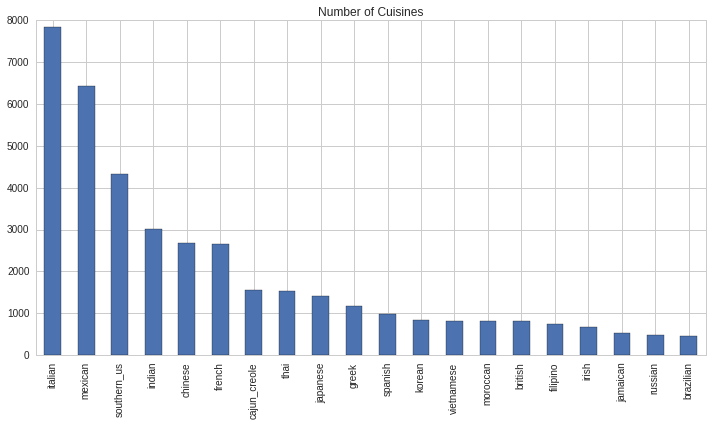

In [48]:
cuisines = df.cuisine.value_counts(sort=True)
cuisines.plot(kind="bar", figsize=(12,6), title="Number of Cuisines")
print("shape:", df.shape)
print("unique cuisine count:", len(df.cuisine.unique()))

### 3.2. What is the most often used ingredients by all cuisine? and what is the most often used ingredients for each cuisine?

In [49]:
# calculating the usage of each ingredient, and for each cuisine
cuisine_dict = defaultdict(Counter)
index_dict = defaultdict(Counter)
total_counter = Counter()
# iterate each row
for index, row in df.iterrows():
    # get the counters
    row_counter = index_dict[row.id] 
    local_counter = cuisine_dict[row.cuisine]
    # count the ingredients usage
    arr = row.ingredients
    for ingredient in row.ingredients:
        key = ingredient.lower()
        # increment each word count
        total_counter[key] += 1
        local_counter[key] += 1
        row_counter[key] += 1
    # update the counters
    cuisine_dict[row.cuisine] = local_counter
    index_dict[row.id] = row_counter
    

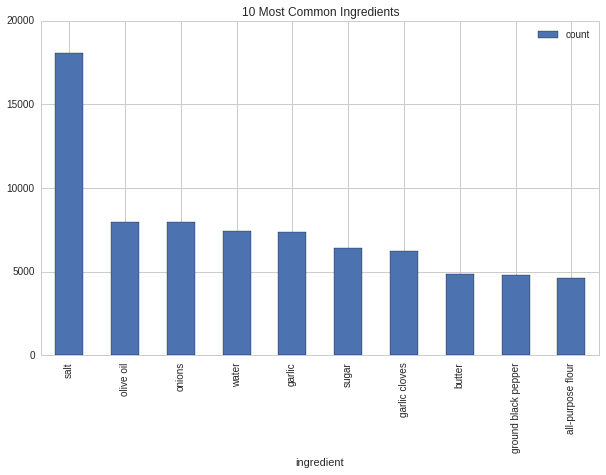

In [50]:
# plotting most common ingredients
most_common_ingredients = pd.DataFrame(total_counter.most_common(10), columns=["ingredient", "count"])
most_common_ingredients.plot(kind="bar", x="ingredient", figsize=(10,6), title="10 Most Common Ingredients")   

Let's draw a word cloud for top 100 ingredients.

/home/morita/anaconda/lib/python2.7/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


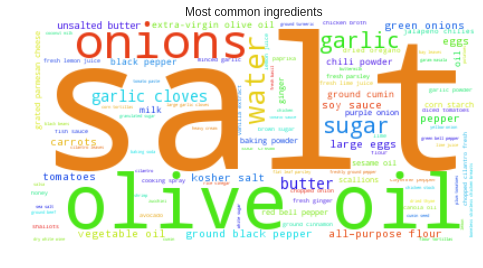

In [6]:
from wordcloud import WordCloud
wordcloudobj = WordCloud( background_color='white')
wordcloud = wordcloudobj.generate_from_frequencies(total_counter.most_common(100))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most common ingredients")
plt.show()

Now let's look at the 100 most common ingredients used for each cuisine

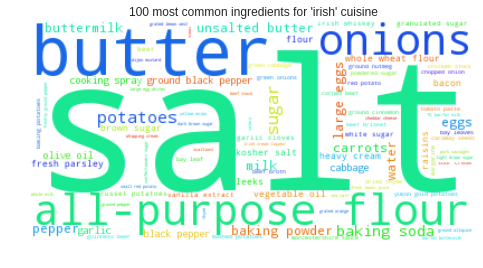

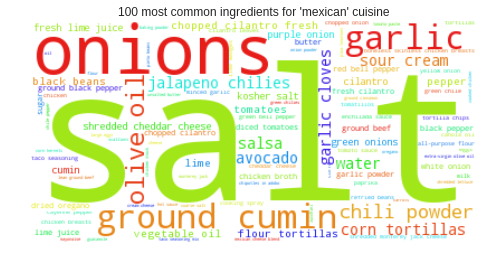

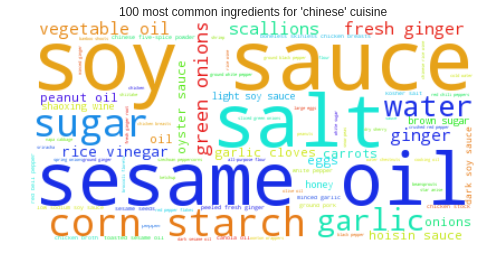

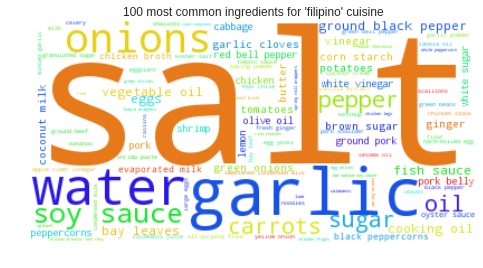

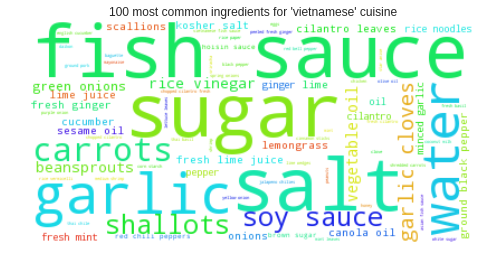

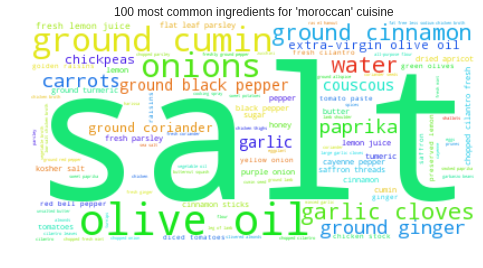

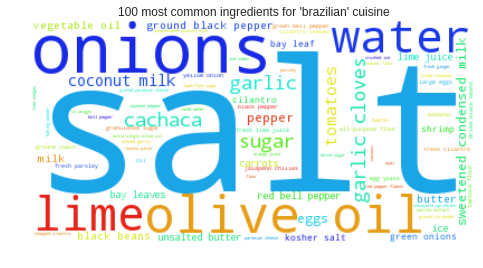

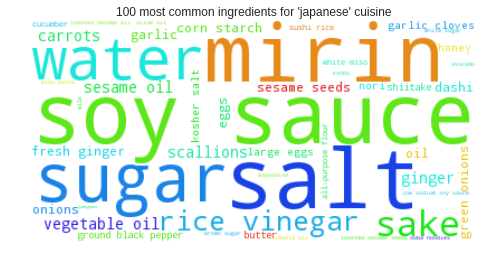

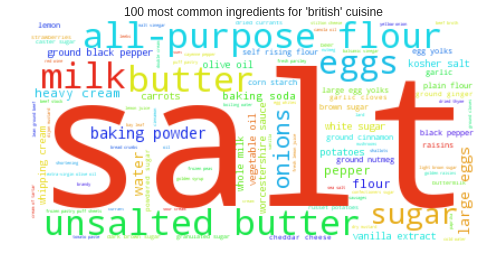

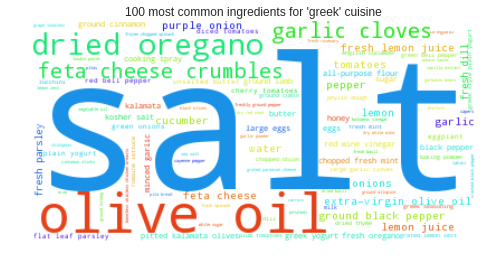

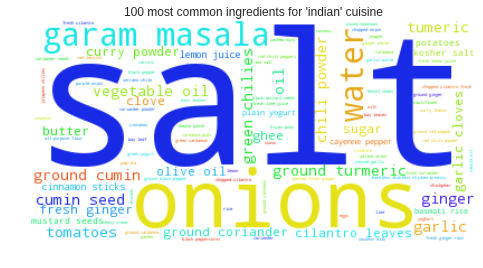

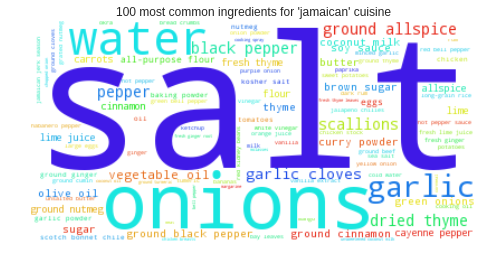

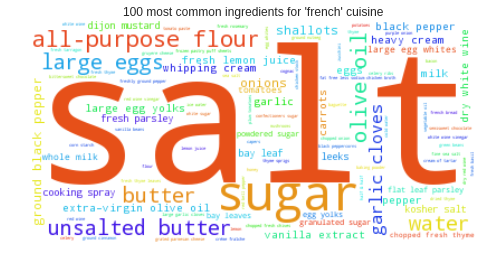

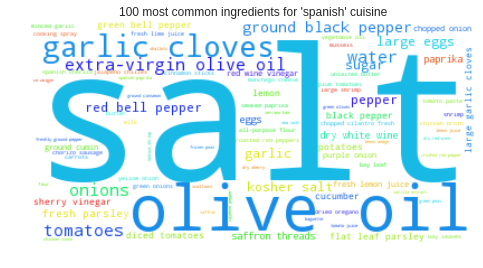

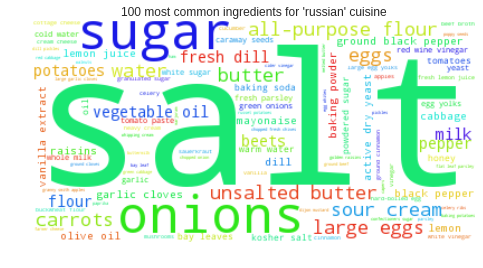

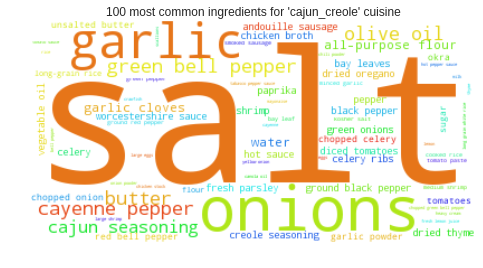

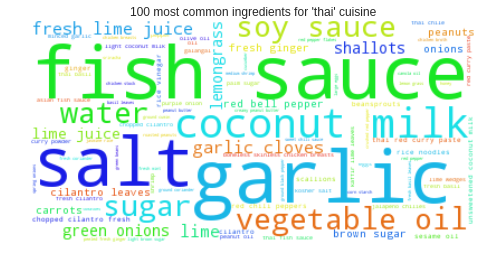

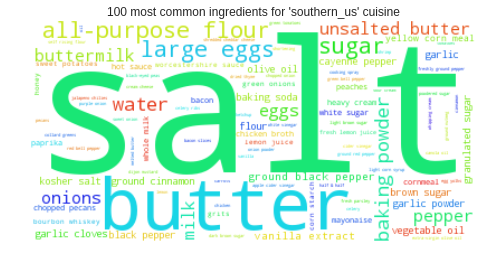

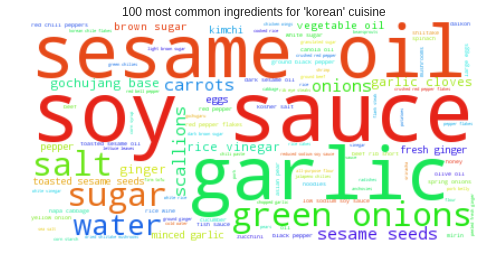

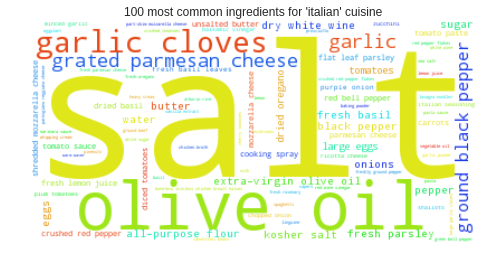

In [7]:
for key, value in cuisine_dict.iteritems():
    wc = wordcloudobj.generate_from_frequencies(value.most_common(100))
    plt.imshow(wc)
    plt.title("100 most common ingredients for '%s' cuisine" % key)
    plt.axis("off")
    plt.show()    

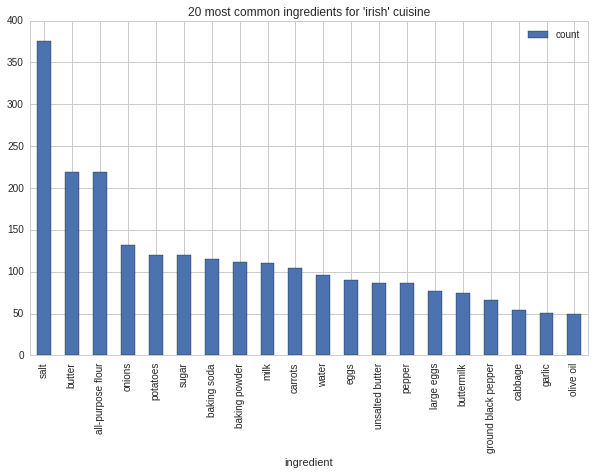

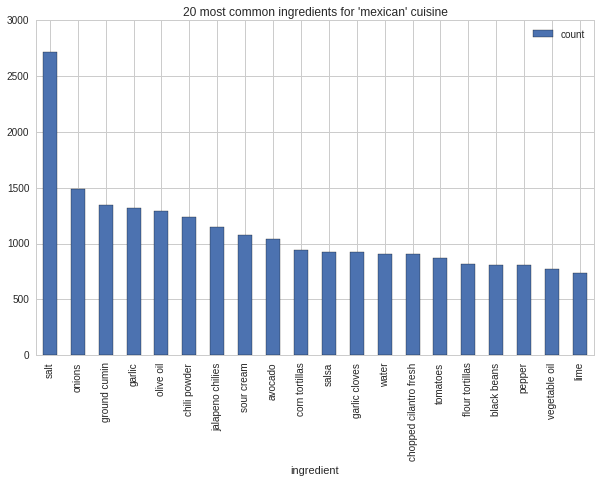

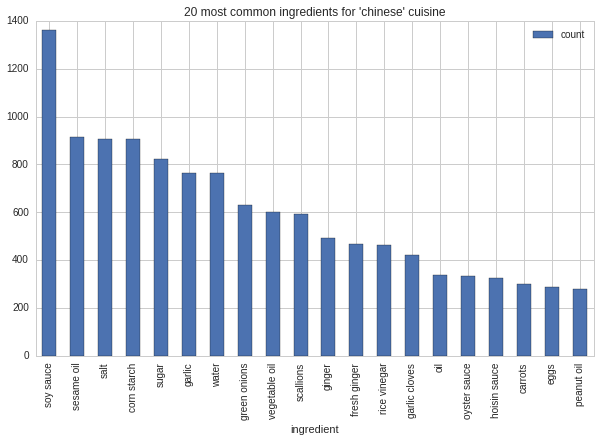

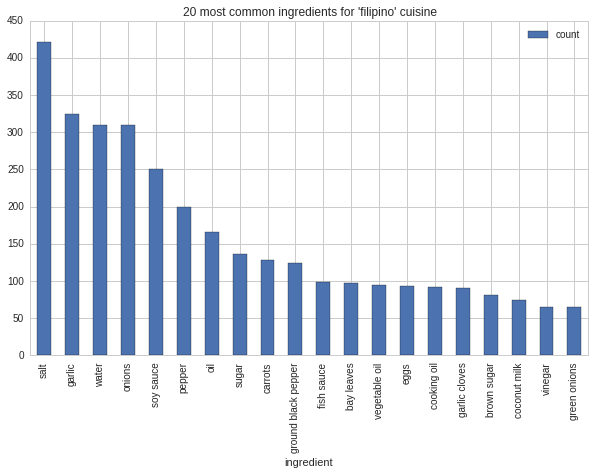

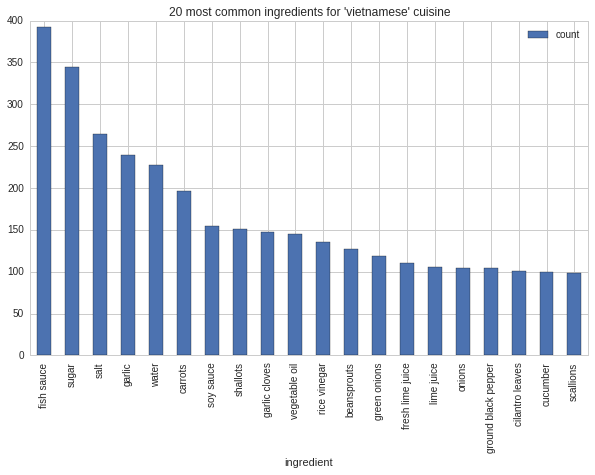

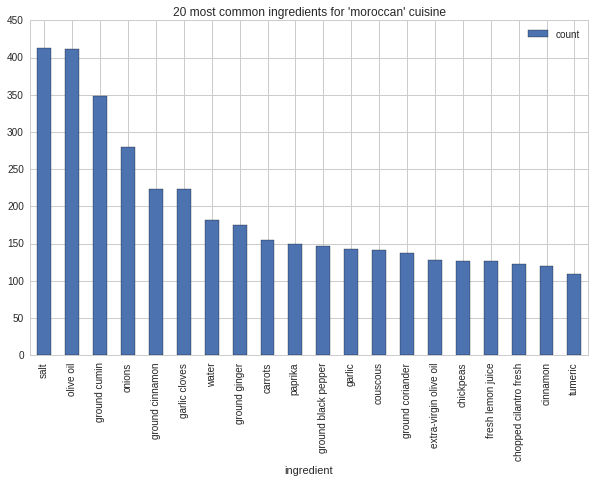

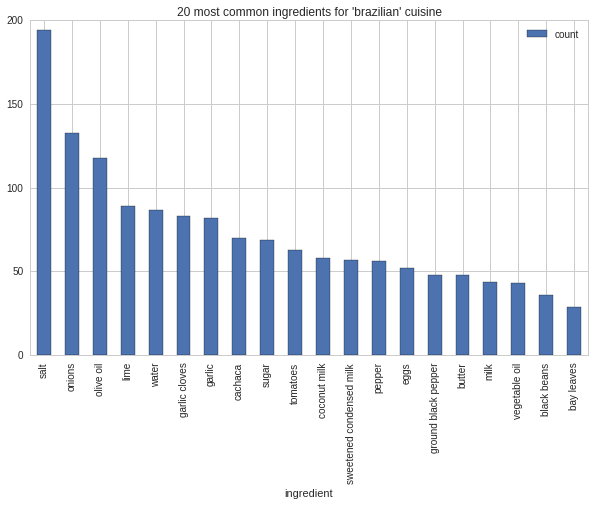

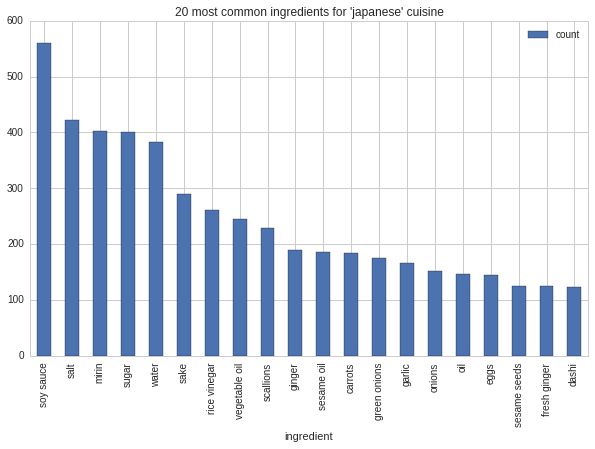

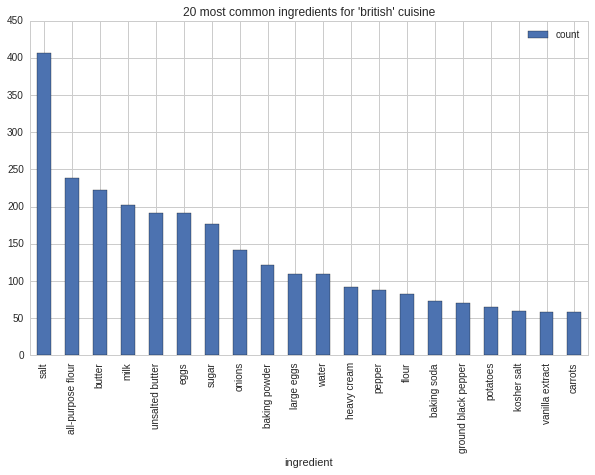

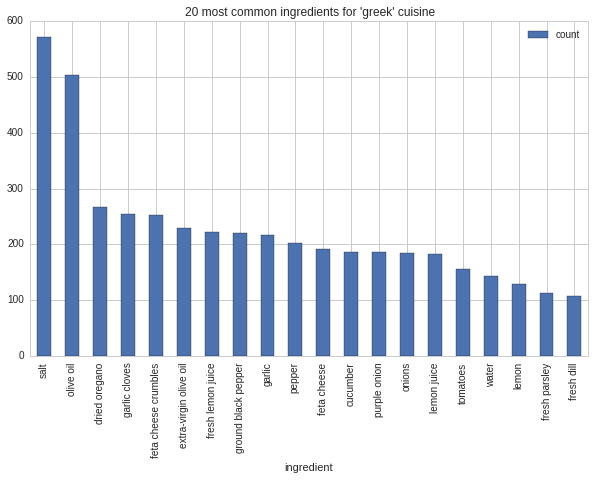

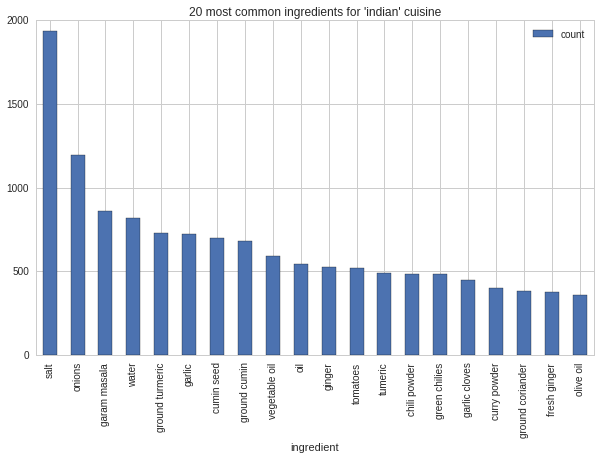

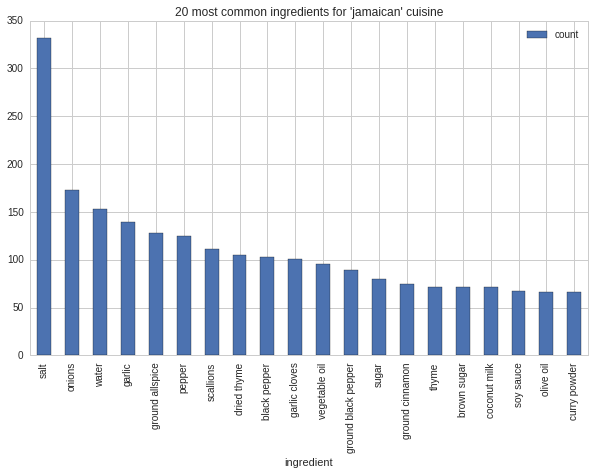

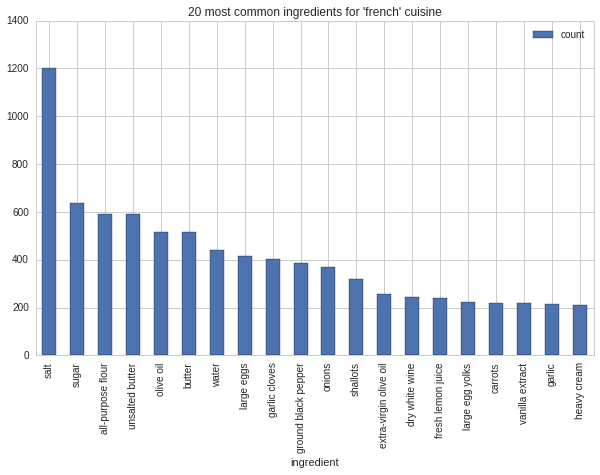

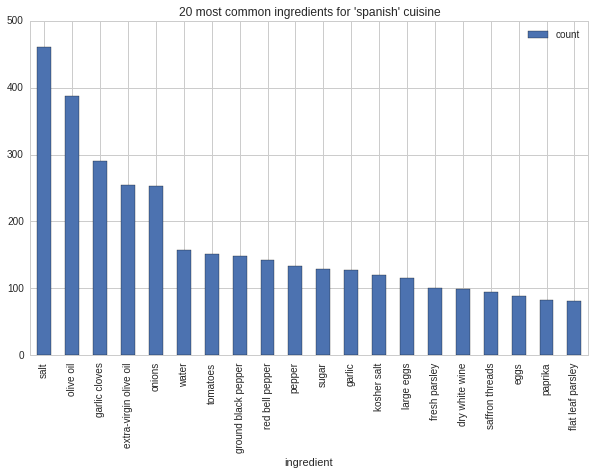

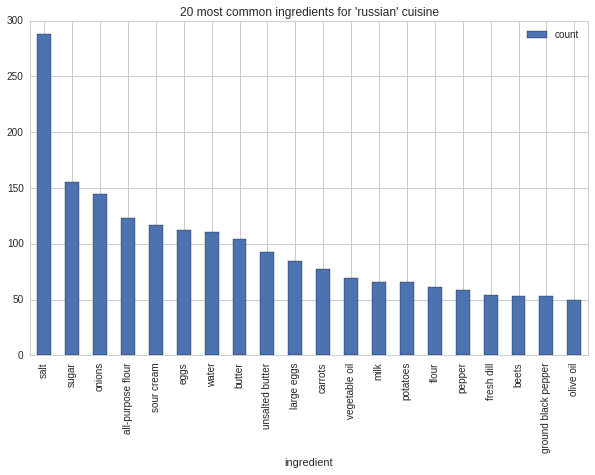

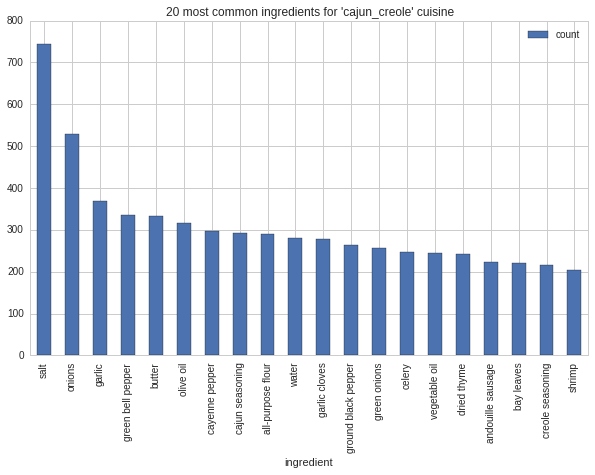

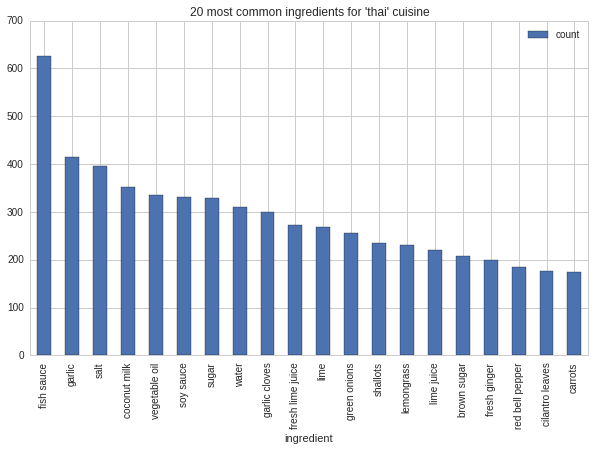

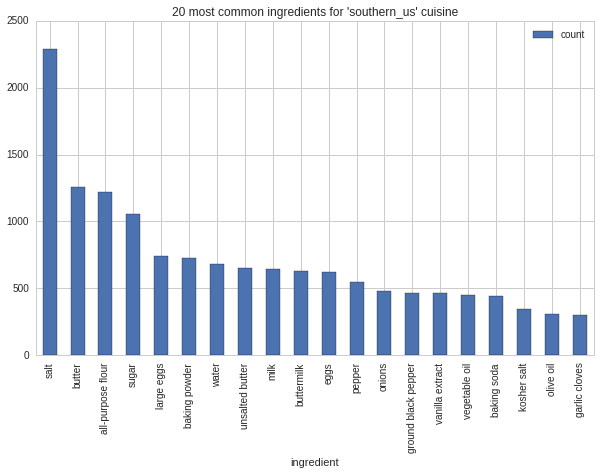

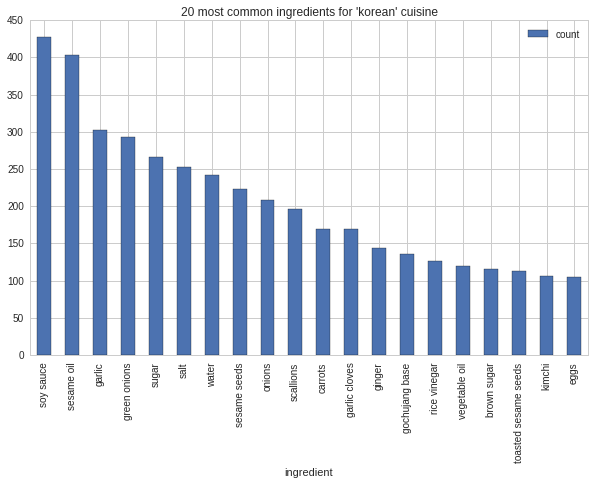

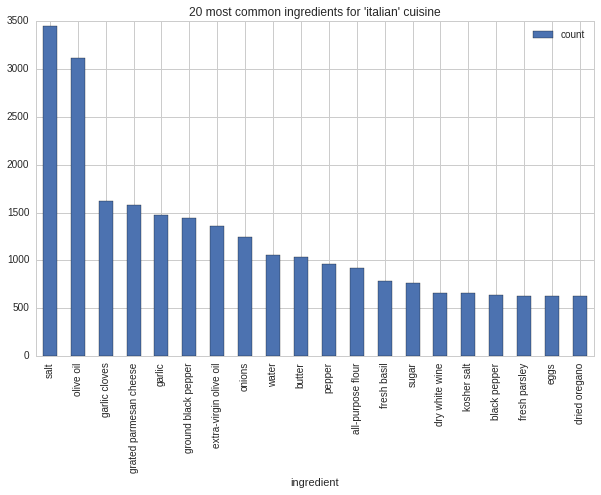

In [8]:
# bar char plot of top 20 most common ingredients
for key, value in cuisine_dict.iteritems():
    mc = pd.DataFrame(value.most_common(20), columns=["ingredient", "count"])
    mc.plot(kind="bar", x="ingredient", figsize=(10,6), title="20 Most Common Ingredients")   
    plt.title("20 most common ingredients for '%s' cuisine" % key)
    plt.show()   

### 3.3. What is the ngram range for each cuisine?

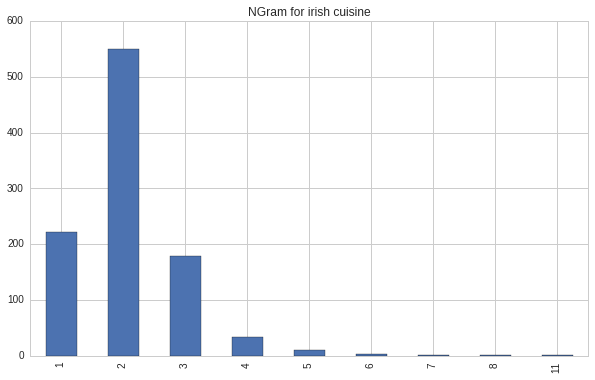

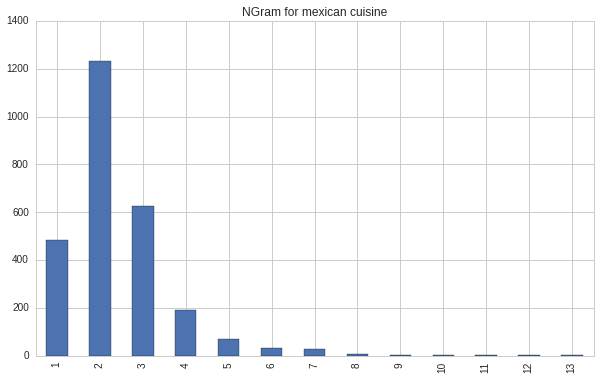

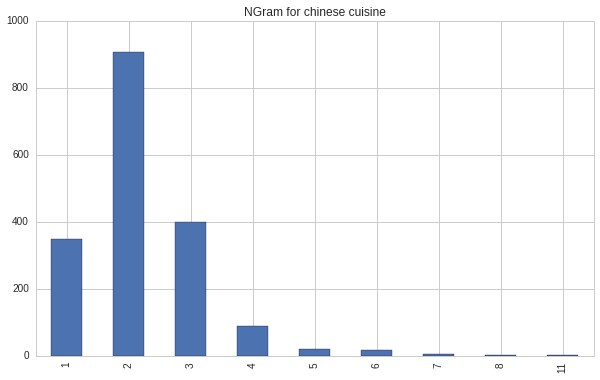

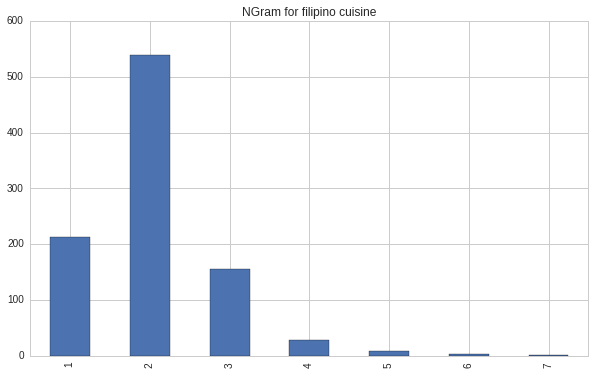

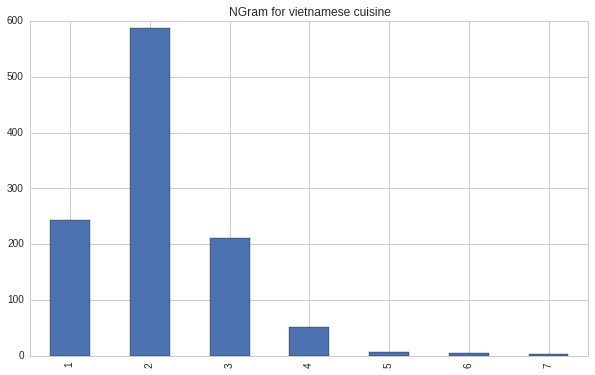

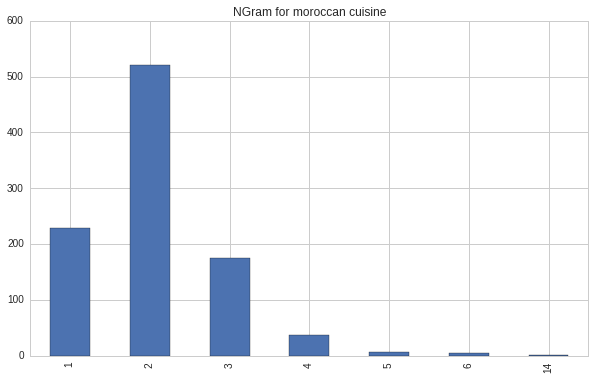

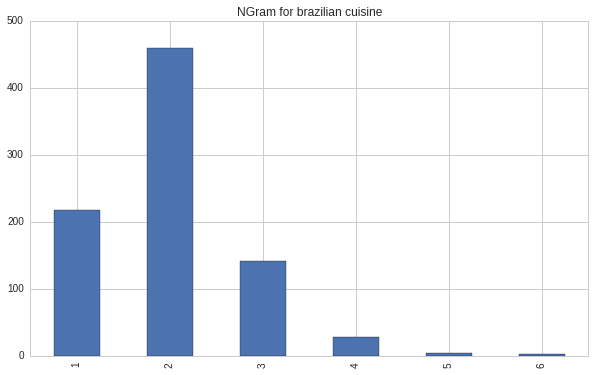

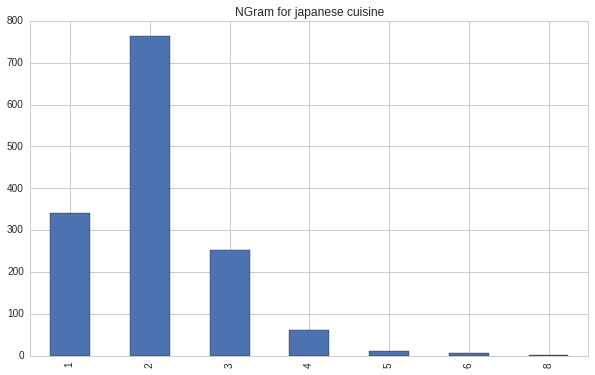

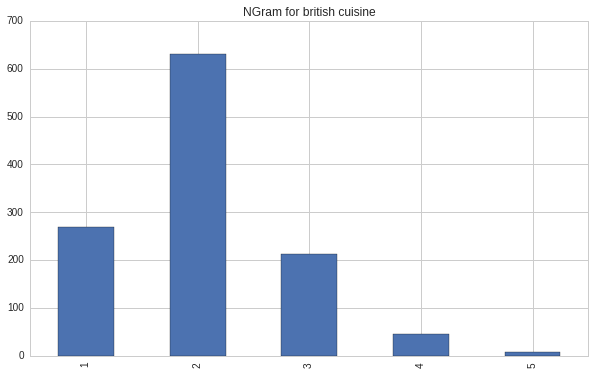

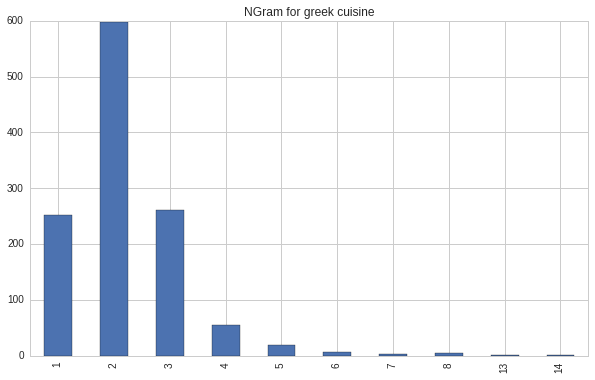

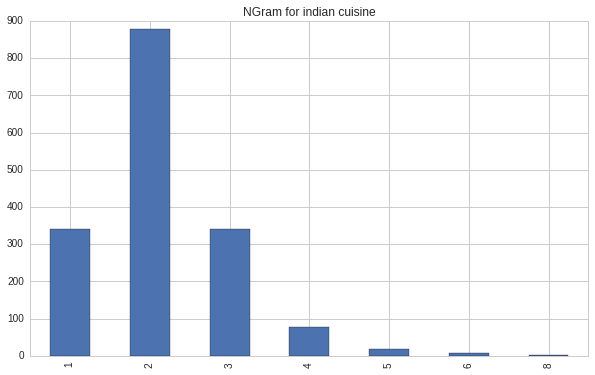

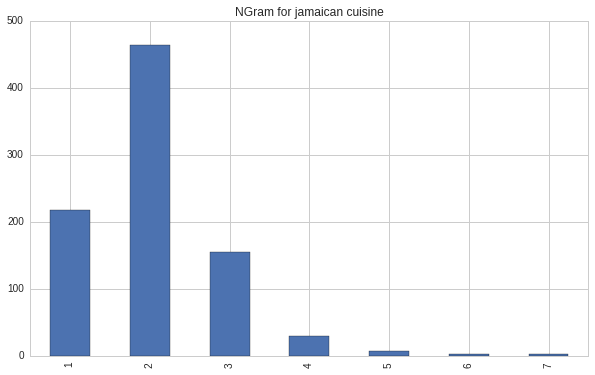

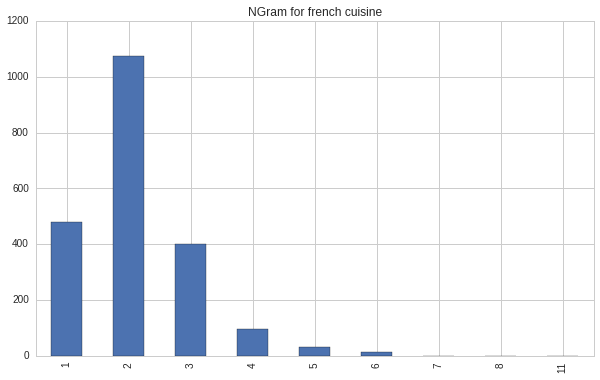

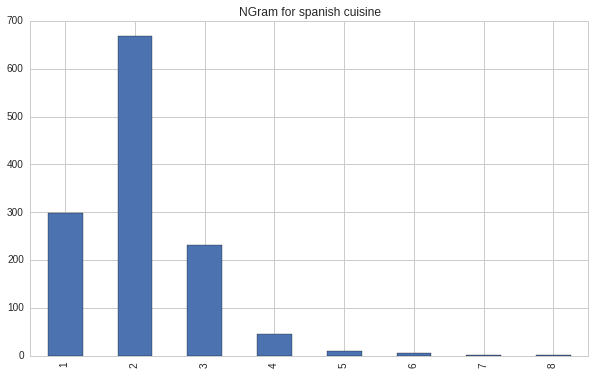

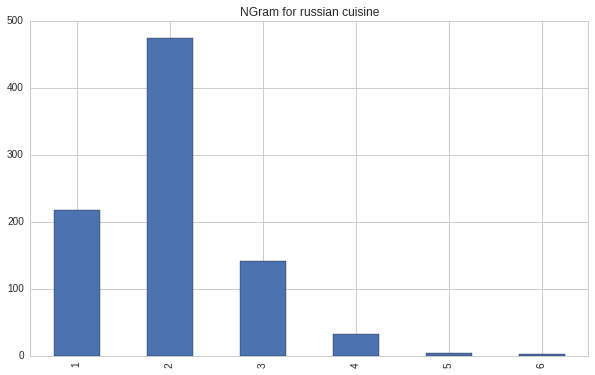

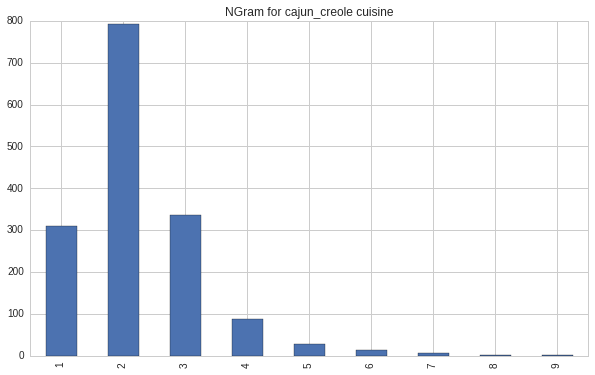

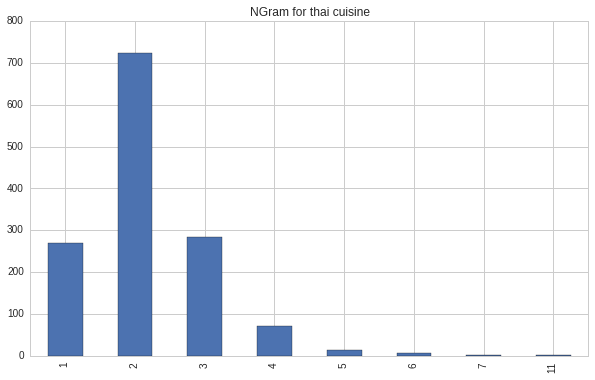

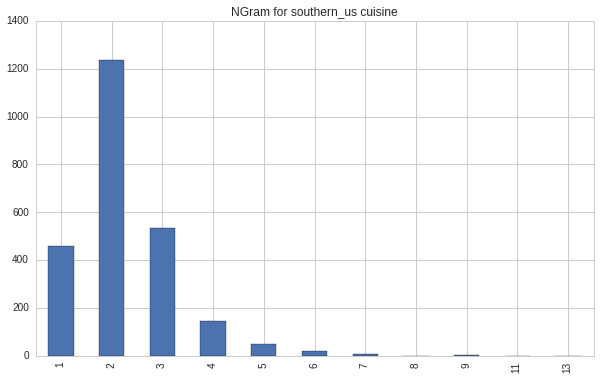

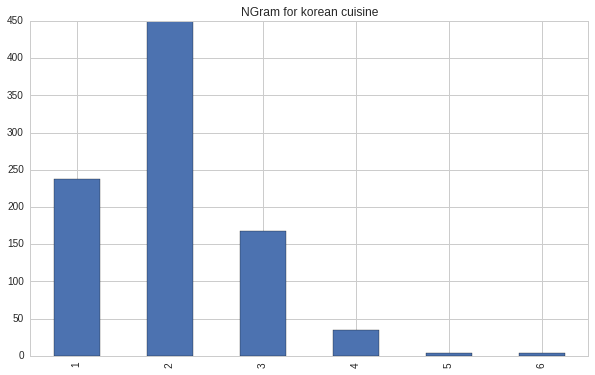

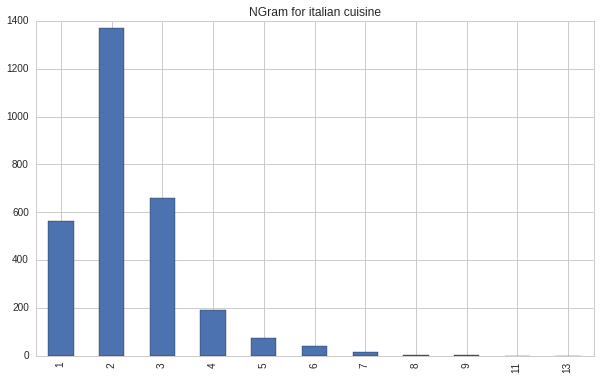

In [51]:
# ngram range for each cuisine
stemmer = PorterStemmer()
ngram_counters = {}
for key, value in cuisine_dict.iteritems():
    rng = [len(word_tokenize(stemmer.stem(wc))) for wc, val in value.iteritems()]  
    local_ngram_counter = Counter(rng)
    ngram_counters[key] = local_ngram_counter
    local_series = pd.Series(local_ngram_counter)
    local_series.plot(kind="bar", figsize=(10,6), title="NGram for %s cuisine" % key)  
    plt.show()



In [10]:
# vector of ngram for each cuisine
ngram_index = {}
for key, value in ngram_counters.iteritems():
    ngram_index[key] = dict(value)
df_ngram = pd.DataFrame.from_dict(ngram_index, orient='index')
df_ngram = df_ngram.fillna(0)
df_ngram

,1,2,3,4,5,6,7,8,11,9,10,12,13,14
brazilian,217,459,142,28,4,3,0,0,0,0,0,0,0,0
british,269,630,213,46,7,0,0,0,0,0,0,0,0,0
cajun_creole,309,793,336,87,27,14,6,1,0,2,0,0,0,0
chinese,348,908,401,90,21,16,4,2,1,0,0,0,0,0
filipino,213,539,155,28,8,3,1,0,0,0,0,0,0,0
french,478,1074,402,97,33,13,1,1,1,0,0,0,0,0
greek,252,597,260,54,19,7,3,4,0,0,0,0,1,1
indian,341,878,340,78,19,7,0,1,0,0,0,0,0,0
irish,221,549,178,34,11,3,1,1,1,0,0,0,0,0
italian,564,1370,660,190,76,42,14,5,1,5,0,0,1,0


### 3.4 Are there groupings between ingredients and cuisines?

In [11]:
# get a vector of cuisines and ingredients
index1 = {}
for key, value in cuisine_dict.iteritems():
    index1[key] = dict(value)
df1 = pd.DataFrame.from_dict(index1, orient='index')
df1 = df1.fillna(0)
cuisine_labels = [key for key, value in df1.iterrows()]
ingredients_labels = list(df1.columns)

# calculating the table of probabilities for the cuisines
inst_count=df1.sum(axis='columns')
df1_prob= df1.div(inst_count,axis='rows')
df1_prob

,lamb stew meat,red cabbage,dijon mustard,rosemary leaves,sweetened coconut,yellow corn meal,fresh chervil,baking chocolate,hard-boiled egg,sweet potatoes,...,tart crust,calabrese sausage,smoked mozzarella,top loin steaks,quahog clams,granita,chioggia,gelato,torpedo rolls,low sodium canned chicken broth
brazilian,0.000000,0.000000,0.000675,0.000000,0.000225,0.000450,0.000000,0.000000,0.000675,0.002249,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
british,0.000000,0.000000,0.002306,0.000128,0.000000,0.000256,0.000000,0.000000,0.000769,0.000897,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cajun_creole,0.000000,0.000051,0.001538,0.000051,0.000000,0.000872,0.000051,0.000000,0.000103,0.000461,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chinese,0.000000,0.000312,0.000219,0.000000,0.000031,0.000000,0.000000,0.000000,0.000094,0.000125,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
filipino,0.000000,0.000000,0.000132,0.000000,0.000000,0.000000,0.000000,0.000000,0.002252,0.000662,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
french,0.000038,0.000115,0.006544,0.000115,0.000000,0.000231,0.000269,0.000038,0.000577,0.000231,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
greek,0.000167,0.000084,0.001337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000167,0.000084,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
indian,0.000105,0.000131,0.000183,0.000000,0.000000,0.000052,0.000000,0.000000,0.000079,0.001468,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
irish,0.000967,0.000161,0.001935,0.000322,0.000161,0.000645,0.000161,0.000161,0.000161,0.000484,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
italian,0.000026,0.000064,0.001275,0.000129,0.000000,0.000824,0.000039,0.000013,0.000077,0.000193,...,0.000013,0.000013,0.000013,0.000026,0.000013,0.000013,0.000013,0.000052,0.000013,0.000013


In [12]:
mds = MDS(n_components=2,  random_state=1)
X = mds.fit_transform(df1_prob.astype(np.float64))
x1 = X[:,0]
y1 = X[:,1]

/home/morita/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


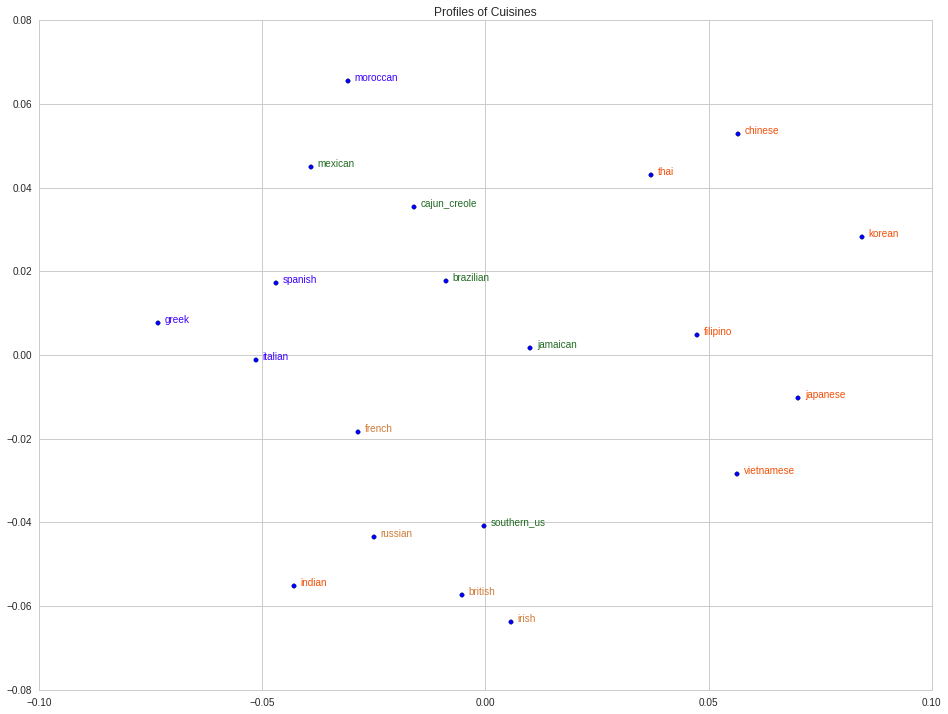

In [13]:
pyl.rcParams['figure.figsize'] = (16.0, 12.0)

fig, ax = plt.subplots()
ax=plt.scatter(x1,y1)
plt.title('Profiles of Cuisines')

colors = {
    'brazilian':    '#216b22',
    'british':      '#ce7a34',
    'cajun_creole': '#216b22',
    'chinese':      '#f24e06',
    'filipino':     '#f24e06',
    'french':       '#ce7a34',
    'greek':        '#3c00ff',
    'indian':       '#f24e06',
    'irish':        '#ce7a34',
    'italian':      '#3c00ff',
    'jamaican':     '#216b22',
    'japanese':     '#f24e06',
    'korean':       '#f24e06',
    'mexican':      '#216b22',
    'moroccan':     '#3c00ff',
    'russian':      '#ce7a34',
    'southern_us':  '#216b22',
    'spanish':      '#3c00ff',
    'thai':         '#f24e06',
    'vietnamese':   '#f24e06'
}

for i, name in enumerate(cuisine_labels):
    plt.annotate(name, (x1[i], y1[i]), color=colors[name], xytext=(7,1), textcoords='offset points')
    
plt.show()

# 4. Model Building

The response variable for the model is the **cuisine**.  It is a categorical variable.

The predictor variable is the **ingredients**. It is a list of text. 

The approach I used for model building is to evaluate each model against the train.json data, and obtain its score.  Model with the highest score will then be tested with train_test split.  And then evaluated against test.json data. 

![](images/train_test_split.png)


Given that this is a text classification problem. The following text feature engineering are tried:

1. Stemming of ingredients
2. Remove all 1 word ingredients
3. TFIDF features (ngram, min-df, max-df)
4. Counting features (percentile)



## 4.1. Modeling Data Preparation

In [52]:
# read the data
df = pd.read_json('../data/train.json')
# mapping categorical response var
df['cuisine_idx'] = pd.factorize(df['cuisine'])[0]
# combine the ingredients list into one sentence
df['ingredients_all'] = df.ingredients.apply(lambda x: " ".join(x))

The following code create new features.

In [54]:
# stem the ingredients
stemmer = PorterStemmer()
df['ingredients_stem'] = df.ingredients_all.apply(lambda x: " ".join([stemmer.stem(word.lower()) for word in x.split(" ")]))
# remove all 1 word ingredients
df['ingredients_exclude1'] = df.ingredients.apply(lambda x: " ".join([ingredient for ingredient in x if len(ingredient.split(" ")) > 1]))
# now stem the ingredients.
df['ingredients_exclude1'] = df.ingredients_exclude1.apply(lambda x: " ".join([stemmer.stem(word.lower()) for word in x.split(" ")]))                         


In [55]:
# set the X, y
X = df['ingredients_all']
y = df['cuisine_idx']

For each model I evaluate the score by cross-validation (5 folds). Below is the code I use for the model evaluation.

In [53]:
# cross validate each model
def cross_val_models(models, X, y, K):
    predLst = []
    for model in models:
        print "Cross_val %s..." % model[0]
        score, sem_score = cross_val_validation(model[1], X, y, K)
        predLst.append({'name': model[0],
                        'score': score,
                        'sem' : sem_score})
    return predLst

# get the mean score, and standard error mean
def cross_val_validation(clf, X, y, K):
    # create a k-fold cross validation iterator of K folds
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # get the mean score, and standard error mean
    scores = cross_val_score(clf, X, y, cv=cv)
    return np.mean(scores), sem(scores)


## 4.1.1. Base models

Evaluate several different models: CountVectorizer, HashVectorizer, TFIDFVectorizer

In [19]:
models = [
    ('count_nb',
        Pipeline([('vect', CountVectorizer(strip_accents='unicode')),
                  ('clf', MultinomialNB())
                 ])
    ),
    ('hashing_nb',
        Pipeline([('vect', HashingVectorizer(strip_accents='unicode', non_negative=True)),
                  ('clf', MultinomialNB()),
                 ])
    ),
    ('tfidf_nb',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode')),
                  ('clf', MultinomialNB())
                 ])
    ),
    ('tfidf_logistic',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode')),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ),
]

In [24]:
predLst = cross_val_models(models, X, y, 5)
predDf = pd.DataFrame.from_dict(predLst)
predDf

Cross_val count_nb...
Cross_val hashing_nb...
Cross_val tfidf_nb...
Cross_val tfidf_logistic...


,name,score,sem
0,count_nb,0.724116,0.002717
1,hashing_nb,0.472595,0.003034
2,tfidf_nb,0.673480,0.002359
3,tfidf_logistic,0.733670,0.003717


Looks like the TFIDFVectorizer with LogisticRegression has the highest score, **0.733**. 

### 4.1.2. Stem ingredient model
Let's try improving it by stemming the words. 

In [26]:
# evaluate TFIDF with stemmed ingredients 
models = [
    ('tfidf_logistic_stem',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode')),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ),
]
X = df['ingredients_stem']
predStemLst = cross_val_models(models, X, y, 5)

Cross_val tfidf_logistic_stem...


In [70]:
predDf = predDf.append(predStemLst, ignore_index=True)
predDf

,name,score,sem
0,count_nb,0.724116,0.002717
1,hashing_nb,0.472595,0.003034
2,tfidf_nb,0.673480,0.002359
3,tfidf_logistic,0.733670,0.003717
0,tfidf_logistic_stem,0.741439,0.003168
0,tfidf_logistic_exclude1,0.703072,0.002400
0,tfidf_logistic_exclude1_ngram,0.696108,0.003434
0,tfidf_logistic_ngram,0.722633,0.002495
0,tfidf_logistic_ngram_23,0.741791,0.003026
1,tfidf_logistic_ngram_24,0.737567,0.002132


Stemming does improve the score to **0.741**.

### 4.1.3. Exclude 1 word ingredient model
Let's improve it futher, by excluding 1 word ingredient from the model.  

In [30]:
# evaluate exclude 1 word ingredient model, 
models = [
    ('tfidf_logistic_exclude1',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode', norm='l2')),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ),
]
X = df['ingredients_exclude1']
predExclude1 = cross_val_models(models, X, y, 5)
predDf = predDf.append(predExclude1, ignore_index=True)
predDf

Cross_val tfidf_logistic_exclude1...


,name,score,sem
0,count_nb,0.724116,0.002717
1,hashing_nb,0.472595,0.003034
2,tfidf_nb,0.673480,0.002359
3,tfidf_logistic,0.733670,0.003717
0,tfidf_logistic_stem,0.741439,0.003168
0,tfidf_logistic_exclude1,0.703072,0.002400


Score does not improve. 

### 4.1.6. TFIDF features model
For this model, the following parameters are tuned:

1. ngram_range. This is for looking at word combination: unigram, bigram, etc.  
2. min_df. This is the lower threshold value where a term have to be present in documents before it is considered. E.g. 0.2 implies that a term have to be in at least 20% of the documents. 
3. max_df. This is the upper threshold value where if a term exceeded its presence in documents it is probably ignored, as it has little meaning. In this context, cooking ingredients, for example, a max_df of 0.8, the term 'water' would be so prevalent, that it would probably exceeded the 80% of the documents. 

#### 4.1.6.1 Ngram_range
Let's combine with ngram. 

In [32]:
# evaluate exclude 1 word ingredient model with ngram
models = [
    ('tfidf_logistic_exclude1_ngram',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode', norm='l2', ngram_range=(2,6))),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ),
]
X = df['ingredients_exclude1']
predExcludeWNGram = cross_val_models(models, X, y, 5)
predDf = predDf.append(predExcludeWNGram, ignore_index=True)
predDf

Cross_val tfidf_logistic_exclude1_ngram...


,name,score,sem
0,count_nb,0.724116,0.002717
1,hashing_nb,0.472595,0.003034
2,tfidf_nb,0.673480,0.002359
3,tfidf_logistic,0.733670,0.003717
0,tfidf_logistic_stem,0.741439,0.003168
0,tfidf_logistic_exclude1,0.703072,0.002400
0,tfidf_logistic_exclude1_ngram,0.696108,0.003434


In [33]:
# evaluate stem with ngram
X = df['ingredients_stem'] # resetting predictor to stemmed ingredients
models = [
    ('tfidf_logistic_ngram',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode', ngram_range=(2,6))),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ),
]
predStemGram = cross_val_models(models, X, y, 5)
predDf = predDf.append(predStemGram, ignore_index=True)
predDf

Cross_val tfidf_logistic_ngram...


,name,score,sem
0,count_nb,0.724116,0.002717
1,hashing_nb,0.472595,0.003034
2,tfidf_nb,0.673480,0.002359
3,tfidf_logistic,0.733670,0.003717
0,tfidf_logistic_stem,0.741439,0.003168
0,tfidf_logistic_exclude1,0.703072,0.002400
0,tfidf_logistic_exclude1_ngram,0.696108,0.003434
0,tfidf_logistic_ngram,0.722633,0.002495


Score went down.  Maybe decrease the range.  Let's cycle through the ranges. 

In [37]:
# evaluating various ngram range 
ranges = [(2,3), (2,4), (2,5)]
models = []
for rng in ranges:
    models.append(('tfidf_logistic_ngram_%d%d' % (rng[0], rng[1]),
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode', ngram_range=rng)),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ))
# cross-validate them
pd = cross_val_models(models, X, y, 5)
predDf = predDf.append(pd)
predDf

Cross_val tfidf_logistic_ngram_23...
Cross_val tfidf_logistic_ngram_24...
Cross_val tfidf_logistic_ngram_25...


,name,score,sem
0,count_nb,0.724116,0.002717
1,hashing_nb,0.472595,0.003034
2,tfidf_nb,0.673480,0.002359
3,tfidf_logistic,0.733670,0.003717
0,tfidf_logistic_stem,0.741439,0.003168
0,tfidf_logistic_exclude1,0.703072,0.002400
0,tfidf_logistic_exclude1_ngram,0.696108,0.003434
0,tfidf_logistic_ngram,0.722633,0.002495
0,tfidf_logistic_ngram_23,0.741791,0.003026
1,tfidf_logistic_ngram_24,0.737567,0.002132


It appears TFIDF with LogisticRegression, with stemmed ingredientns and 2,3 ngram improves the score by a little bit to 0.741791.  Still within the standard error.  Not as significant. 

#### 4.1.6.2. min_df and max_df

In [78]:
# let's try 0.1 min_df, and 0.9 max_df
models = [
    ('tfidf_logistic_ngram_minmax_df',
        Pipeline([('vect', TfidfVectorizer(strip_accents='unicode', ngram_range=(2,6), min_df=0.1, max_df=0.9)),
                  ('clf', LogisticRegression(C=1e9))
                 ])
    ),
]
predMinMaxDf = cross_val_models(models, X, y, 5)
predDf = predDf.append(predMinMaxDf, ignore_index=True)
predDf

Cross_val tfidf_logistic_ngram_minmax_df...


,name,score,sem
0,count_nb,0.724116,0.002717
1,hashing_nb,0.472595,0.003034
2,tfidf_nb,0.673480,0.002359
3,tfidf_logistic,0.733670,0.003717
4,tfidf_logistic_stem,0.741439,0.003168
5,tfidf_logistic_exclude1,0.703072,0.002400
6,tfidf_logistic_exclude1_ngram,0.696108,0.003434
7,tfidf_logistic_ngram,0.722633,0.002495
8,tfidf_logistic_ngram_23,0.741791,0.003026
9,tfidf_logistic_ngram_24,0.737567,0.002132


Got even worse score. 

### 4.1.7. Select percentile model

##### Random Forest Model

In [ ]:
# find best estimators
# find best depth

clf_6 = Pipeline([
    ('vect', CountVectorizer(
                stop_words=stopwords
    )),
    ('tfidf',TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=500, random_state=1))
])
# re-evaluate
cross_val_validation(clf_6, X, y, 5)  

##### SGD (Stochastic Gradient Descent)

##### SVM (Support Vector Machines)

### Unsupervised Approach
#### LDA Topic Modeling

### Model Evaluation

In [ ]:
# split data to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    
    print "Accuracy on training set:"
    print clf.score(X_train, y_train)
    print "Accuracy on testing set:"
    print clf.score(X_test, y_test)
    
    y_pred = clf.predict(X_test)
    print "Classification Report:"
    print metrics.classification_report(y_test, y_pred)
    print "Confusion Matrix:"
    print metrics.confusion_matrix(y_test, y_pred)

In [ ]:
train_and_evaluate(clf_6, X_train, X_test, y_train, y_test)

### Model Prediction

## Summary